# Select DEG from pairwise comparison

## Content
1. I combined all the DEG results from the previous DESeq2 analysis
2. I selected DEG, saved a smaller table only contain DEG
3. I used the unfiltered data to make 2 plots
    1. A venn plot showing DEG overlap between three pairs, regardless of the log2FC direction of DEGs
    2. Volcano plot showing how many DEGs between each pair.
    
This jupyter notebook provides you examples about two facts:
1. Pandas is very important in handling your data, and prepare your data for visulization
2. Seaborn can give you a nice volcano plot using only several line of code, but a lot more matplotlib knowledge is needed if you want to customize it. Alternatively, you can use Adobe AI.



In [1]:
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# seaborn can change matplot default to make plots suitable for paper
sns.set_context("paper")

## Load all files

In [4]:
gene_meta = pd.read_csv('./gene_metadata.csv.gz', index_col=0)
gene_meta.head()

,chrom,source,feature,start,end,strand,gene_type,gene_name,level,mgi_id,havana_gene,tag
gene_id,,,,,,,,,,,,
ENSMUSG00000102693.1,chr1,HAVANA,gene,3073253,3074322,+,TEC,4933401J01Rik,2,MGI:1918292,OTTMUSG00000049935.1,NaN
ENSMUSG00000064842.1,chr1,ENSEMBL,gene,3102016,3102125,+,snRNA,Gm26206,3,MGI:5455983,NaN,NaN
ENSMUSG00000051951.5,chr1,HAVANA,gene,3205901,3671498,-,protein_coding,Xkr4,2,MGI:3528744,OTTMUSG00000026353.2,NaN
ENSMUSG00000102851.1,chr1,HAVANA,gene,3252757,3253236,+,processed_pseudogene,Gm18956,1,MGI:5011141,OTTMUSG00000049958.1,pseudo_consens
ENSMUSG00000103377.1,chr1,HAVANA,gene,3365731,3368549,-,TEC,Gm37180,2,MGI:5610408,OTTMUSG00000049960.1,NaN


In [5]:
dev_times = ['E10.5', 'E14.5', 'P0']

pairs = list(itertools.combinations(dev_times, 2))

total_deg = []
for cluster_a, cluster_b in pairs:
    # read each pair DEG result
    deg_results = pd.read_csv(f'{cluster_a}_vs_{cluster_b}.deg_results.csv', index_col=0)
    deg_results['cluster_a'] = cluster_a
    deg_results['cluster_b'] = cluster_b
    deg_results['pair_name'] = f'{cluster_a}_vs_{cluster_b}'
    
    total_deg.append(deg_results)
    
# concatenate into a single table
total_deg = pd.concat(total_deg)
total_deg.index.name = 'gene_id'

# add gene name using the gene meta
total_deg['gene_name'] = total_deg.index.map(gene_meta['gene_name'])

In [6]:
# this table contain DEG from all three pairs
total_deg.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,weight,cluster_a,cluster_b,pair_name,gene_name
gene_id,,,,,,,,,,,
ENSMUSG00000000001.4,12317.642241,0.297103,0.126877,2.341665,1.919793e-02,4.375757e-02,1.147604,E10.5,E14.5,E10.5_vs_E14.5,Gnai3
ENSMUSG00000000028.15,2376.622873,1.353595,0.166360,8.136550,4.067019e-16,3.960103e-15,1.147604,E10.5,E14.5,E10.5_vs_E14.5,Cdc45
ENSMUSG00000000031.16,2383.991337,1.775855,0.163946,10.831967,2.428815e-27,4.404670e-26,1.151647,E10.5,E14.5,E10.5_vs_E14.5,H19
ENSMUSG00000000037.17,281.576119,0.015541,0.324316,0.047918,9.617817e-01,9.854592e-01,1.302372,E10.5,E14.5,E10.5_vs_E14.5,Scml2
ENSMUSG00000000049.11,1.165938,-2.733085,4.912529,-0.556350,5.779717e-01,1.000000e+00,0.000000,E10.5,E14.5,E10.5_vs_E14.5,Apoh


In [7]:
# very few genes do not have P value, see DESeq2 documentation for why
# Search"p-values set to NA" http://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html
total_deg = total_deg[~total_deg['padj'].isna()].copy()

In [8]:
# add -lgP for plotting
total_deg['-log10padj'] = -np.log10(total_deg['padj'])

# some gene has extreme p value, it make the plotting hard, we manually set a maximum of them
p_max = 150
total_deg.loc[total_deg['-log10padj'] > p_max, '-log10padj'] = p_max

/Users/hq/miniconda3/envs/genome_book/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Select DEG

In [9]:
# this is the cutoff to select DEG, DESeq2 table is unfiltered.
padj_cutoff = 1e-5
log2_fc_abs_cutoff = 2

### Construct a bool deg_judge, and add it into total_deg table

We do not filter the table because we want those insignificant data in the plot as well

But we added a column to indicate which genes are DEG

In [10]:
# construct a single bool judge using both cutoff
deg_judge = (total_deg['padj'] < padj_cutoff) & (total_deg['log2FoldChange'].abs() > log2_fc_abs_cutoff)

total_deg['DEG'] = deg_judge

In [11]:
total_deg.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,weight,cluster_a,cluster_b,pair_name,gene_name,-log10padj,DEG
gene_id,,,,,,,,,,,,,
ENSMUSG00000000001.4,12317.642241,0.297103,0.126877,2.341665,1.919793e-02,4.375757e-02,1.147604,E10.5,E14.5,E10.5_vs_E14.5,Gnai3,1.358947,False
ENSMUSG00000000028.15,2376.622873,1.353595,0.166360,8.136550,4.067019e-16,3.960103e-15,1.147604,E10.5,E14.5,E10.5_vs_E14.5,Cdc45,14.402293,False
ENSMUSG00000000031.16,2383.991337,1.775855,0.163946,10.831967,2.428815e-27,4.404670e-26,1.151647,E10.5,E14.5,E10.5_vs_E14.5,H19,25.356087,False
ENSMUSG00000000037.17,281.576119,0.015541,0.324316,0.047918,9.617817e-01,9.854592e-01,1.302372,E10.5,E14.5,E10.5_vs_E14.5,Scml2,0.006361,False
ENSMUSG00000000049.11,1.165938,-2.733085,4.912529,-0.556350,5.779717e-01,1.000000e+00,0.000000,E10.5,E14.5,E10.5_vs_E14.5,Apoh,-0.000000,False


### Save selected DEG

In [12]:
selected_deg = total_deg[total_deg['DEG']]

selected_deg.to_csv('TotalDEG.csv.gz')

selected_deg['pair_name'].value_counts()

E10.5_vs_P0       3520
E10.5_vs_E14.5    2109
E14.5_vs_P0        487
Name: pair_name, dtype: int64

## Plot Venn

You need to install a small package called matplotlib_venn

```shell
pip install matplotlib_venn
```


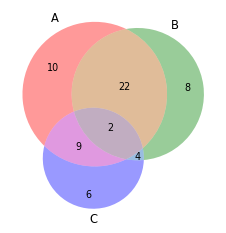

In [13]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
 
# Make the diagram
venn3(subsets = (10, 8, 22, 6, 9, 4, 2))
plt.show()


In [14]:
# turn the selected DEG table into a dummy table, contain 0 and 1 indicates the DEG hits
dummy_table = selected_deg.reset_index().groupby(
    ['gene_id', 'pair_name']).apply(lambda i: 1).unstack(fill_value=0)
dummy_table

pair_name,E10.5_vs_E14.5,E10.5_vs_P0,E14.5_vs_P0
gene_id,,,
ENSMUSG00000000028.15,0,1,1
ENSMUSG00000000031.16,0,1,0
ENSMUSG00000000058.6,0,1,0
ENSMUSG00000000093.6,0,1,0
ENSMUSG00000000126.11,1,0,0
...,...,...,...
ENSMUSG00000118202.1,0,1,0
ENSMUSG00000118219.1,0,1,1
ENSMUSG00000118269.1,0,1,0


In [15]:
category_code = dummy_table.astype(str).apply(lambda i: i.str.cat(), axis=1)
category_code

gene_id
ENSMUSG00000000028.15    011
ENSMUSG00000000031.16    010
ENSMUSG00000000058.6     010
ENSMUSG00000000093.6     010
ENSMUSG00000000126.11    100
                        ... 
ENSMUSG00000118202.1     010
ENSMUSG00000118219.1     011
ENSMUSG00000118269.1     010
ENSMUSG00000118494.1     010
ENSMUSG00000118604.1     010
Length: 3918, dtype: object

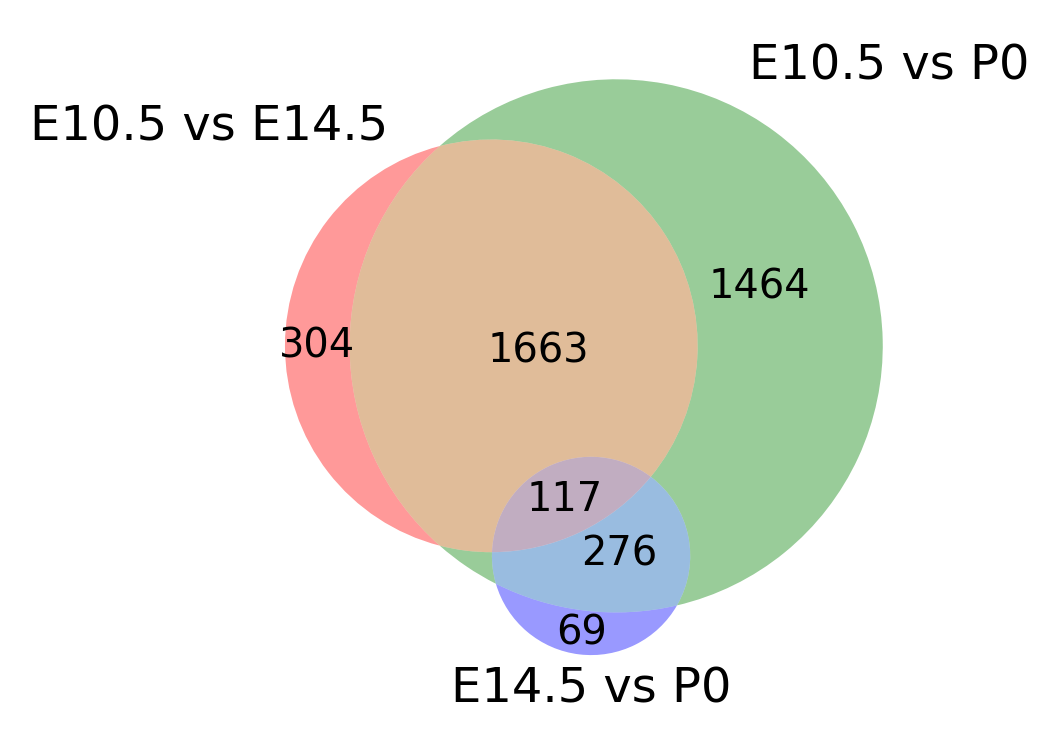

In [16]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
 
# Make the diagram

fig, ax = plt.subplots(figsize=(3, 3), dpi=300)
venn3(subsets = ((category_code == '100').sum(), 
                 (category_code == '010').sum(), 
                 (category_code == '110').sum(), 
                 (category_code == '001').sum(), 
                 (category_code == '101').sum(), 
                 (category_code == '011').sum(), 
                 (category_code == '111').sum()), 
      ax=ax,
      set_labels=list(dummy_table.columns.str.replace('_', ' ')),
     set_colors=('r', 'g', 'b'),)

fig.savefig('DEG_venn.pdf')

## Plot Volcano

### easy version 

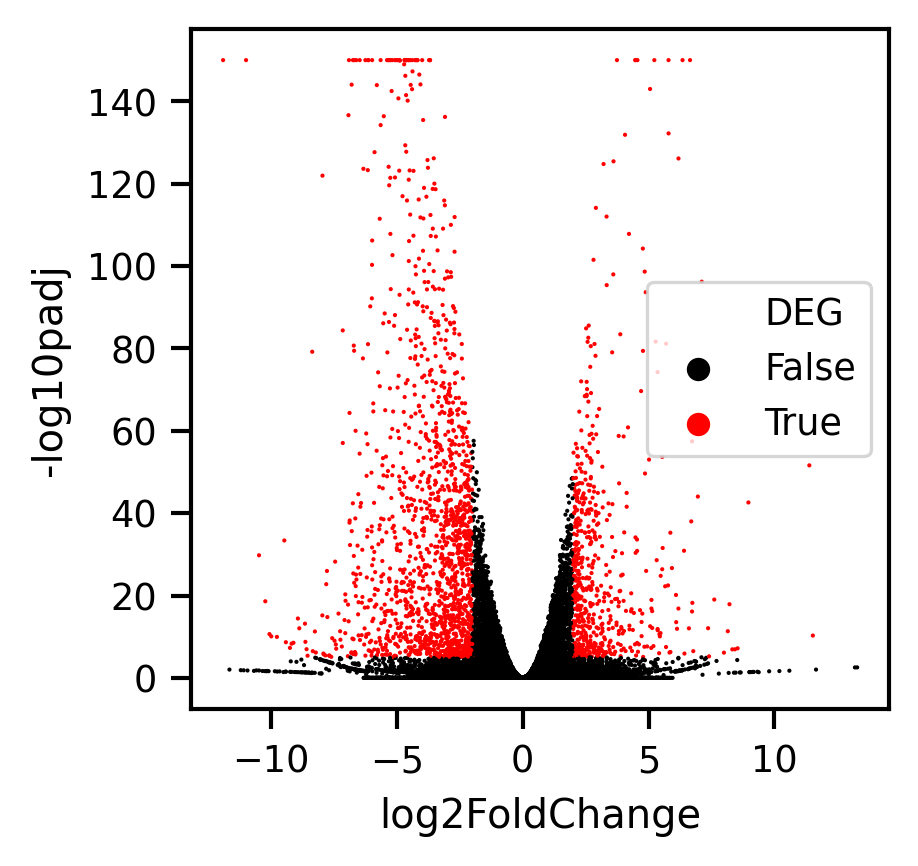

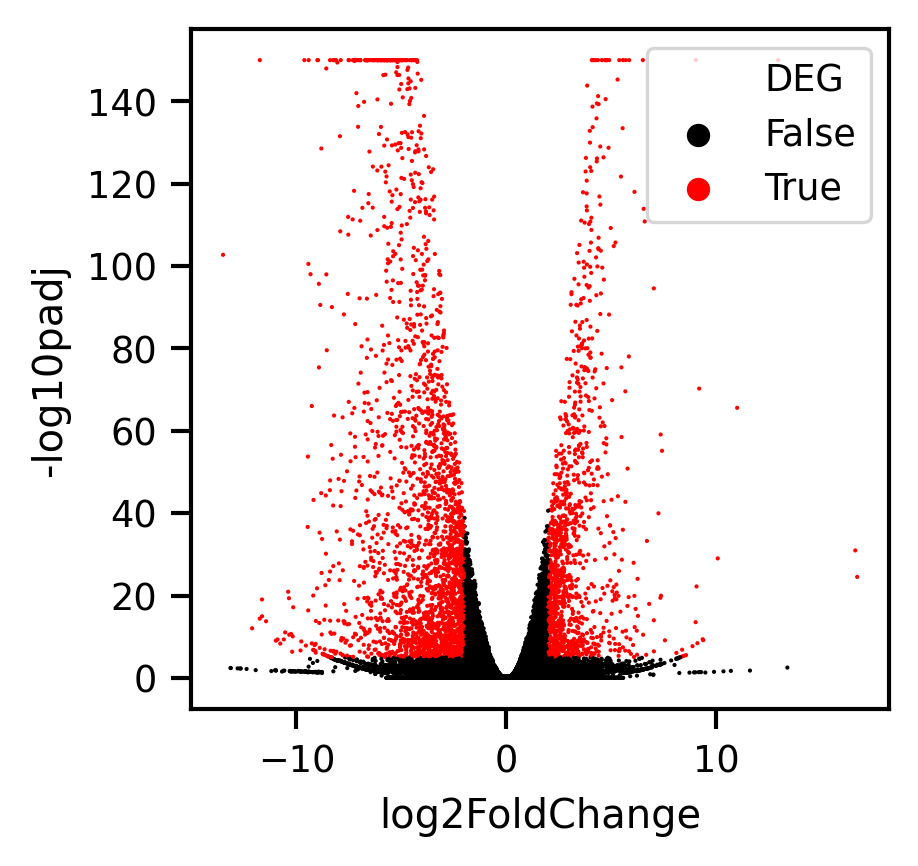

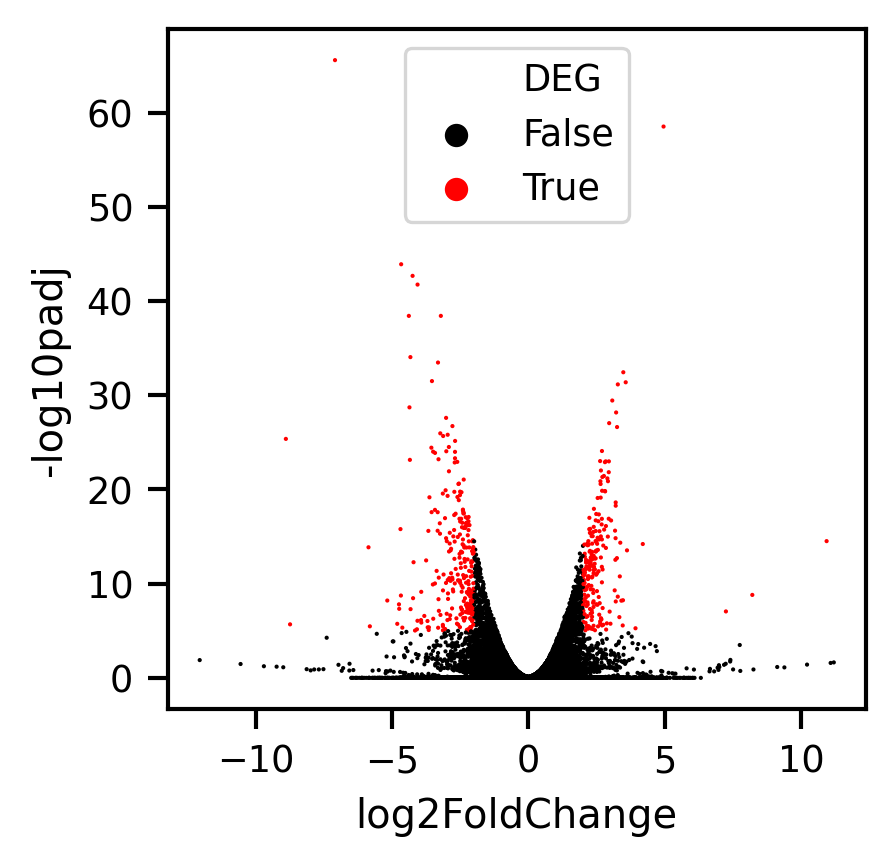

In [18]:

# Majority work can be done using seaborn
# If you need customization, go to Adobe AI or learn more about matplotlib

for pair_name, sub_df in total_deg.groupby('pair_name'):
    # init a figure and a ax
    fig, ax = plt.subplots(figsize=(3, 3), dpi=300)
    
    # plot volcano (scatter) plot
    sns.scatterplot(ax=ax, 
                    data=sub_df, 
                    x='log2FoldChange', 
                    y='-log10padj', 
                    s=1, 
                    linewidth=0, 
                    hue='DEG', 
                    palette={True:'red', False:'black'})
    
    # save to PDF, you can use AI to make changes!
    fig.savefig(f'DEG_volcano.{pair_name}.pdf')

### hard version

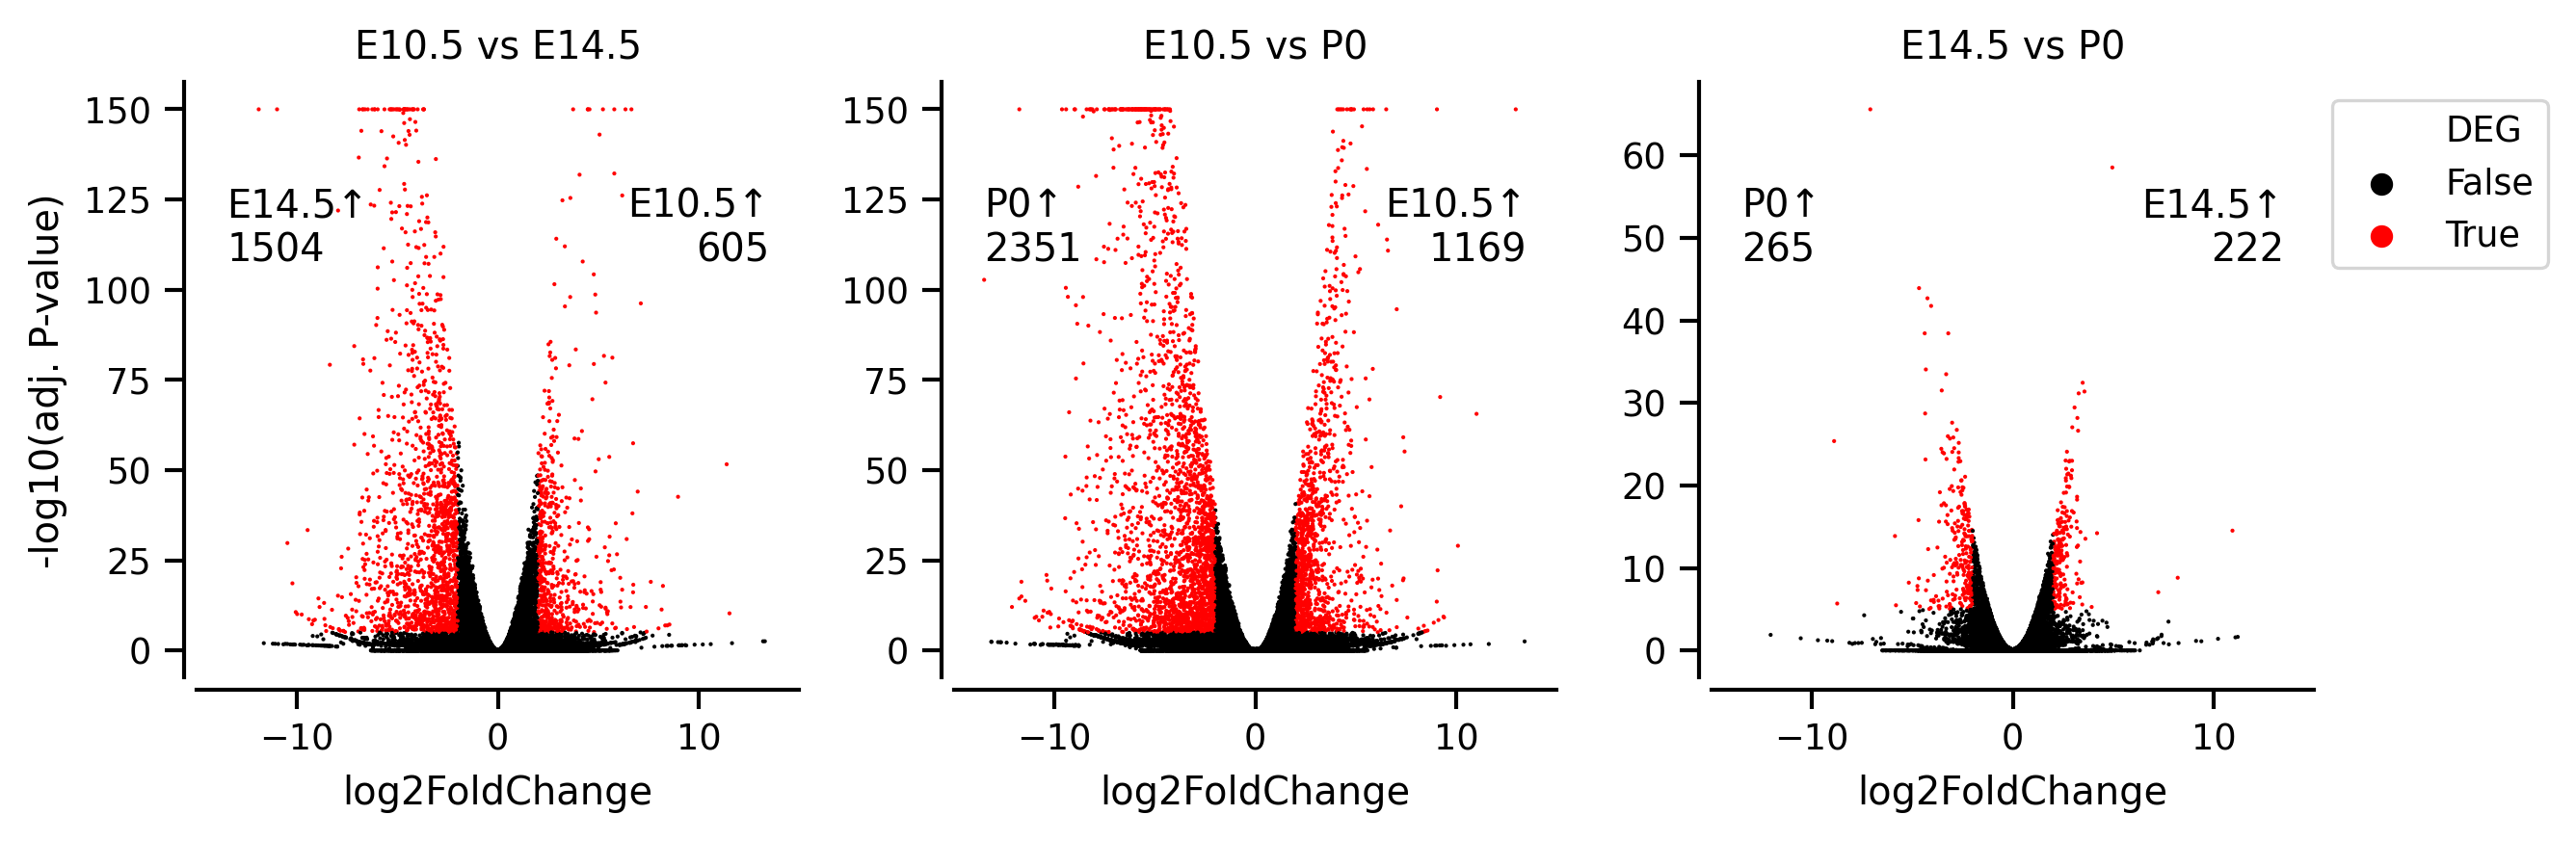

In [19]:
# How to adjust everything in python with several line of code, this needs much more matplotlib knowledge
fig, axes = plt.subplots(figsize=(9, 3), dpi=300, ncols=3)

for ax, (pair_name, sub_df) in zip(axes, total_deg.groupby('pair_name')):
    if ax.is_last_col():
        legend='brief'
    else:
        legend=None
    
    sns.scatterplot(ax=ax, data=sub_df, 
                    x='log2FoldChange', y='-log10padj', 
                    s=1, linewidth=0, hue='DEG', 
                    legend=legend,
                    palette={True:'red', False:'black'})
    
    # add the text annotation about how many genes on each side
    time1, time2 = pair_name.split('_vs_')
    # this line counts the DEG based on sign of log2FC
    n_deg = sub_df.groupby(sub_df['log2FoldChange'] > 0)['DEG'].sum().astype(int)
    # these lines added the annotation
    ax.text(x=0.95, y=0.7, s=f'{time1}↑\n{n_deg[True]}', ha='right', transform=ax.transAxes)
    ax.text(x=0.05, y=0.7, s=f'{time2}↑\n{n_deg[False]}', ha='left', transform=ax.transAxes)
    
    # these lines set all parameters
    ax.set_title(pair_name.replace('_', ' '))
    ax.set(xlim=(-15, 15)) # limitation of x axis range
    
    # y axis labels
    if ax.is_first_col():
        ax.set(ylabel='-log10(adj. P-value)')
    else:
        ax.set(ylabel='')
        
    # move legend to outside
    if legend:
        ax.legend(bbox_to_anchor=(1, 1))
    
    # remove top and right boarder, make axis nicer
    sns.despine(ax=ax, offset=3)

# make more space between plots
fig.tight_layout()

# save
fig.savefig('DEG_volcano.all_three_pairs.pdf')